# testsol - osmid_conectivity

__Problem:__ aup.graph_from_hippo generates networks inside a given polygon. Sometimes, when using city/political boundaries to generate a OSMnx network, the resulting OSMnx network is composed of multiple networks that do not connect to each other because of those political boundaries.

This notebook that tests ways to __remove parts of a OSMnx network which are not connected to the rest (main) OSMnx network of a city.__

* __Result was successfull__. From here a function was developed and inplemented on __Script 09-hex-speed.py__

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
pip install networkx[default]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx

In [11]:
# Save fixed nodes and edges to local to view in QGIS?
gis_check = True

# Save fixed edges to db osmnx > edges_speed_test to test aup.graph_from_hippo?
db_save = False

## a) Find centroid of city

### a.1) Load municipalities gdf

In [3]:
city = 'Aguascalientes'
schema = 'metropolis'
table = 'metro_gdf_2020'
query = f"SELECT * FROM {schema}.{table} WHERE \"city\" LIKE \'{city}\'"
city_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(city_gdf.shape)
city_gdf.head(1)

(3, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",Aguascalientes


### a.2) Load ageb gdf from municipalities gdf

In [4]:
ageb_gdf = gpd.GeoDataFrame()

# Load city states (CVE_ENT)
cve_ent_list = list(city_gdf.CVE_ENT.unique())
for cve_ent in cve_ent_list:
    
    #Load muns in each city state
    cve_mun_list = list(city_gdf.loc[city_gdf.CVE_ENT == cve_ent].CVE_MUN.unique())
    # To avoid error that happens when there's only one MUN: [SQL: SELECT * FROM censo_mza.censo_mza_2020 WHERE ("CVE_ENT" = '02') AND "CVE_MUN" IN ('001',) ]
    if len(cve_mun_list) >= 2:
        cve_mun_tpl = str(tuple(cve_mun_list))
    else:
        cve_mun_list.append(cve_mun_list[0])
        cve_mun_tpl = str(tuple(cve_mun_list))

    # Load AGEBs and concat
    query = f"SELECT * FROM marco.ageb_2020 WHERE (\"cve_ent\" = \'{cve_ent}\') AND \"cve_mun\" IN {cve_mun_tpl} "
    ageb_gdf = pd.concat([ageb_gdf,aup.gdf_from_query(query, geometry_col='geometry')])

# Show
print(ageb_gdf.shape)
ageb_gdf.head(1)

(392, 6)


,cve_geo_ageb,cve_ent,cve_mun,cve_loc,cve_ageb,geometry
0,010010001216A,01,001,0001,216A,"POLYGON ((-102.27058 21.87363, -102.27083 21.8..."


### a.3) Find centroid of AGEBs

/tmp/ipykernel_9506/760750170.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_centroid = gpd.GeoDataFrame(geometry=aoi.centroid)


<Axes: >

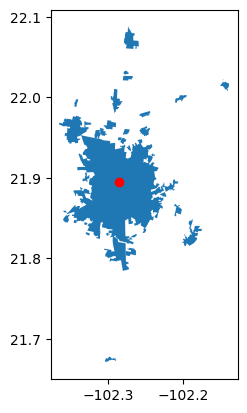

In [5]:
aoi = ageb_gdf.dissolve()
aoi_centroid = gpd.GeoDataFrame(geometry=aoi.centroid)

# Show
fig, ax = plt.subplots(1,1)
aoi_centroid.plot(ax=ax,zorder=2,color='red')
aoi.plot(ax=ax,zorder=1)

## b) Find Network node closest to centroid

### b.1) Load network nodes

In [6]:
aoi = city_gdf.dissolve()

# Download Network used to calculate nearest note to each poi
network_schema = 'osmnx'
edges_table = 'edges_speed'
nodes_table = 'nodes'
G, nodes, edges = aup.graph_from_hippo(aoi, schema=network_schema, edges_folder=edges_table, nodes_folder=nodes_table)

In [7]:
# Show
print(nodes.shape)
nodes.head(1)

(51434, 4)


,x,y,street_count,geometry
osmid,,,,
272921360,-102.295073,21.872876,3,POINT (-102.29507 21.87288)


In [8]:
# Show
print(edges.shape)
edges.head(1)

(121037, 19)


,,,osmid,oneway,lanes,name,highway,length,geometry,grade,grade_abs,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
u,v,key,,,,,,,,,,,,,,,,,,,
3003502781,8424128014,0,296556921,True,1,Carretera Aguascalietes-San Marcos,primary,17.585,"LINESTRING (-102.20343 21.99742, -102.20327 21...",0.0,0.0,None,None,MEX 25,80,None,None,None,None,4.0,0.263775


### b.2) Find closest node

In [9]:
### Find nearest osmnx node for each DENUE point.
nearest = aup.find_nearest(G, nodes, aoi_centroid, return_distance= False)

# Show
print(nearest.shape)
nearest.head(1)

(1, 2)


,geometry,osmid
0,POINT (-102.28575 21.89511),7795331388


### b.3) Find all nodes that have a path to the nearest node to centroid (Takes about 415s for Aguascalientes)

In [12]:
# Get the unique osmid of the target node
target_osmid = nearest.osmid.unique()[0]

# Convert the graph to an undirected graph (To ignore nodes which are not reachable due to direction of streets)
G_undirected = G.to_undirected()

# Initialize a list to store nodes that have a path to the target node
osmids_with_path = []

# Iterate over all nodes in the graph
for node in G_undirected.nodes():
    # Check if there is a path from the current node to the target node
    if nx.has_path(G_undirected, node, target_osmid):
        # If a path exists, append the node to the list
        osmids_with_path.append(node)

### b.4) Filter nodes using osmids_with_path

In [20]:
nodes_gdf = nodes.reset_index()
filtered_nodes = nodes_gdf.loc[nodes_gdf['osmid'].isin(osmids_with_path)].copy()

# Show
print(f"Deleted {nodes.shape[0] - filtered_nodes.shape[0]} unconnected nodes.")
print(filtered_nodes.shape)
filtered_nodes.head(1)

Deleted 51364 unconnected nodes.
(70, 5)


,osmid,x,y,street_count,geometry
5783,1103032963,-102.33579,22.051572,3,POINT (-102.33579 22.05157)


### b.5) Filter edges using osmids_with_path

In [14]:
edges_gdf = edges.reset_index()
filtered_edges = edges_gdf.loc[(edges_gdf['u'].isin(osmids_with_path)) | (edges_gdf['v'].isin(osmids_with_path))].copy()

# Show
print(f"Deleted {edges.shape[0] - filtered_edges.shape[0]} unconnected edges.")
print(filtered_edges.shape)
filtered_edges.head(1)

Deleted 116 unconnected edges.
(120921, 22)


,u,v,key,osmid,oneway,lanes,name,highway,length,geometry,...,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
0,3003502781,8424128014,0,296556921,True,1,Carretera Aguascalietes-San Marcos,primary,17.585,"LINESTRING (-102.20343 21.99742, -102.20327 21...",...,None,None,MEX 25,80,None,None,None,None,4.0,0.263775


### c) Save to view result in QGIS

In [21]:
if gis_check:
    filtered_nodes.to_file("../../../data/external/temporal_fromjupyter/proximity_v2/networkx_has_path_nodes.gpkg", driver='GPKG')
    filtered_edges.to_file("../../../data/external/temporal_fromjupyter/proximity_v2/networkx_has_path_edges.gpkg", driver='GPKG')

## Test resulting Network [Success]

Do we also need to upload a 'nodes speed' for the Network to work? Test by loading aup.graph_from_hippo using nodes and recently filtered edges_speed. Resulting nodes_test and edges_test shape should be that of filtered nodes and edges.

In [16]:
if db_save:
    aup.gdf_to_db_slow(filtered_edges, "edges_speed_test", schema='osmnx', if_exists="replace")

In [17]:
if db_save:
    aoi = city_gdf.dissolve()
    
    # Download Network used to calculate nearest note to each poi
    network_schema = 'osmnx'
    edges_table = 'edges_speed_test'
    nodes_table = 'nodes'
    G, nodes_test, edges_test = aup.graph_from_hippo(aoi, schema=network_schema, edges_folder=edges_table, nodes_folder=nodes_table)

In [18]:
if db_save:
    # Show test
    print(nodes_test.shape)
    nodes_test.head(1)

In [19]:
if db_save:
    # Show test
    print(edges_test.shape)
    edges_test.head(1)